**IMPORTS**

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Embedding, Attention, LayerNormalization, Dense
from sklearn import tree
from tensorflow.keras import models, layers
import warnings

from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import precision_recall_curve,precision_recall_fscore_support
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
warnings.filterwarnings('ignore')

**LOADING AND PREPROCESSING DATASET**

In [105]:
path = './clean_data.csv'
df = pd.read_csv(path, encoding='utf-8')
print("Data Shape:", df.shape)

Data Shape: (30609, 2)


,Sentence,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,AND 1 = utl_inaddr.get_host_address ( ...,1
2,select * from users where id = '1' or @ @1 ...,1
3,"select * from users where id = 1 or 1#"" ( ...",1
4,select name from syscolumns where id = ...,1
5,select * from users where id = 1 +$+ or 1 =...,1
6,"1; ( load_file ( char ( 47,101,116,99,47...",1
7,select * from users where id = '1' or ||/1 ...,1
8,select * from users where id = '1' or \.<\ ...,1
9,? or 1 = 1 --,1


In [106]:
X = df['Sentence']
y = df['Label']
print(X.shape, y.shape)

(30609,) (30609,)
Dataset Input: 
 0                    " or pg_sleep  (  __TIME__  )  --
1     AND 1  =  utl_inaddr.get_host_address   (    ...
2     select * from users where id  =  '1' or @ @1 ...
3     select * from users where id  =  1 or 1#"  ( ...
4     select name from syscolumns where id   =     ...
Name: Sentence, dtype: object
Dataset Label: 
 0    1
1    1
2    1
3    1
4    1
Name: Label, dtype: int64


In [107]:
import nltk
nltk.download('stopwords')
vectorizer = CountVectorizer(min_df = 2, max_df = 0.8, stop_words = stopwords.words('english'))
X = vectorizer.fit_transform(X.values.astype('U')).toarray()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2) #Train 80 Test 20
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(24487, 6509)
(24487,)
(6122, 6509)
(6122,)


In [109]:
f1_dict = {}
precision_dict = {}
recall_dict = {}
accuracy_dict = {}
train_accuracy = {}
validation_accuracy = {}
test_accuracy = {}

## Support function

In [110]:
# Function to plot the history graphs of the training and validation curves during training
def plot_history(history):
    history_dict = history.history
    train_loss = history_dict['loss']    # Training loss over epochs
    val_loss = history_dict['val_loss']    # Validation loss over epochs
    epochs = range(1, len(history_dict['loss'])+1)
    plt.plot(epochs, train_loss,'b', label='Training error')
    plt.plot(epochs, val_loss,'b', color="orange", label='Validation error')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_historyAcc(history):
    history_dict = history.history
    train_acc = history_dict['accuracy']    # Training loss over epochs
    val_acc = history_dict['val_accuracy']    # Validation loss over epochs
    epochs = range(1, len(history_dict['accuracy'])+1)
    plt.plot(epochs, train_acc,'b', label='Training accuracy')
    plt.plot(epochs, val_acc,'b', color="orange", label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Function to plot the confusion matrix
def plot_confusion_matrix(conf_matrix):    
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
    
    plt.xlabel('Predicted Value', fontsize=18)
    plt.ylabel('Actual Value', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

def plot_roc_auc(model, X_test, y_test):
    # Predict probabilities for the positive class
    y_pred_proba = model.predict(X_test)
    
    # Extract probabilities for the positive class (assuming binary classification)
    if y_pred_proba.shape[1] > 1:
        y_pred_proba = y_pred_proba[:, 1]
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Classifier (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model.name}')
    plt.legend(loc='lower right')
    plt.show()

def plot_report(y_test, y_pred):
    conf_matrix_model = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(conf_matrix_model)
    print(classification_report(y_test, y_pred, target_names=["Non-Intrusion", "Intrusion"]))

**LOGISTIC REGRESSION**

In [111]:
lr_clf = LogisticRegression()
y_pred_lr = lr_clf.fit(X_train, y_train)
y_pred = y_pred_lr.predict(X_test)
print(f"Accuracy of Logistic Regression on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of Logistic Regression on test set : {f1_score(y_pred, y_test)}")

# Updates model score to f1_dict
f1_dict["LogisticRegression"] = f1_score(y_pred, y_test)
precision_dict["LogisticRegression"] = precision_score(y_pred, y_test)
recall_dict["LogisticRegression"] = recall_score(y_pred, y_test)
accuracy_dict['LogisticRegression'] = accuracy_score(y_pred, y_test)

**RANDOM FOREST**

In [112]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_test)
print(f"Accuracy of Random Forest on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of Random Forest on test set : {f1_score(y_pred, y_test)}")

# Updates model score to f1_dict
f1_dict["RandomForest"] = f1_score(y_pred, y_test)
precision_dict["RandomForest"] = precision_score(y_pred, y_test)
recall_dict["RandomForest"] = recall_score(y_pred, y_test)
accuracy_dict['RandomForest'] = accuracy_score(y_pred, y_test)

**SUPPORT VECTOR MACHINES**

In [113]:
svm_clf = SVC(gamma = 'auto')
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
print(f"Accuracy of SVM on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of SVM on test set : {f1_score(y_pred, y_test)}")

# Updates model score to f1_dict
f1_dict["SVM"] = f1_score(y_pred, y_test)
precision_dict["SVM"] = precision_score(y_pred, y_test)
recall_dict["SVM"] = recall_score(y_pred, y_test)
accuracy_dict['SVM'] = accuracy_score(y_pred, y_test)

**NAIVE BAYES**

In [114]:
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)
y_pred = nb_clf.predict(X_test)
print(f"Accuracy of Naive Bayes on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of Naive Bayes on test set : {f1_score(y_pred, y_test)}")

# Updates model score to f1_dict
f1_dict["NaiveBayes"] = f1_score(y_pred, y_test)
precision_dict["NaiveBayes"] = precision_score(y_pred, y_test)
recall_dict["NaiveBayes"] = recall_score(y_pred, y_test)
accuracy_dict['NaiveBayes'] = accuracy_score(y_pred, y_test)

**DECISION TREES**


In [115]:
DT = tree.DecisionTreeClassifier()
DT.fit(X_train, y_train)
y_pred = DT.predict(X_test)
print(f"Accuracy of Naive Bayes on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of Naive Bayes on test set : {f1_score(y_pred, y_test)}")

# Updates model score to f1_dict
f1_dict["DecisionTree"] = f1_score(y_pred, y_test)
precision_dict["DecisionTree"] = precision_score(y_pred, y_test)
recall_dict["DecisionTree"] = recall_score(y_pred, y_test)
accuracy_dict['DecisionTree'] = accuracy_score(y_pred, y_test)

**CONVOLUTIONAL NEURAL NETWORK**

In [116]:
X_train1 = X_train.reshape(-1, 1, 6509)
X_test1 = X_test.reshape(-1, 1, 6509)

In [117]:
train_shape = X_train1.shape[1:]

In [118]:
model = models.Sequential(name="CNN")
model.add(layers.Conv1D(32, 1, activation = 'relu', input_shape = train_shape))
model.add(layers.Conv1D(32, 1, activation = 'relu'))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation = 'sigmoid'))
model.summary()
model.compile(optimizer = 'adam', loss = tf.keras.losses.BinaryCrossentropy(), metrics = ['accuracy'])

history_cnn = model.fit(X_train1, y_train, batch_size =32, epochs = 10, validation_data = (X_test1, y_test))

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 1, 32)             208320    
                                                                 
 conv1d_9 (Conv1D)           (None, 1, 32)             1056      
                                                                 
 flatten_4 (Flatten)         (None, 32)                0         
                                                                 
 dense_67 (Dense)            (None, 1)                 33        
                                                                 
Total params: 209,409
Trainable params: 209,409
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
766/766 [==============================] - 5s 6ms/step - loss: 0.1974 - accuracy: 0.9271 - val_loss: 0.0959 - val_accuracy: 0.9662
Epoch 2/10
766/766 [===========================

In [119]:
y_pred = model.predict(X_test1).flatten()
# y_pred1 = [1 if x>-0.5 else 0 for x in y_pred]
y_pred = np.round(y_pred)
print(f"Accuracy of CNN on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of CNN on test set : {f1_score(y_pred, y_test)}")

# Updates model score to f1_dict
f1_dict["CNN"] = f1_score(y_pred, y_test)
precision_dict["CNN"] = precision_score(y_pred, y_test)
recall_dict["CNN"] = recall_score(y_pred, y_test)
accuracy_dict['CNN'] = accuracy_score(y_pred, y_test)

192/192 [==============================] - 1s 3ms/step
Accuracy of CNN on test set : 0.9689643907219863
F1 Score of CNN on test set : 0.9563820018365472


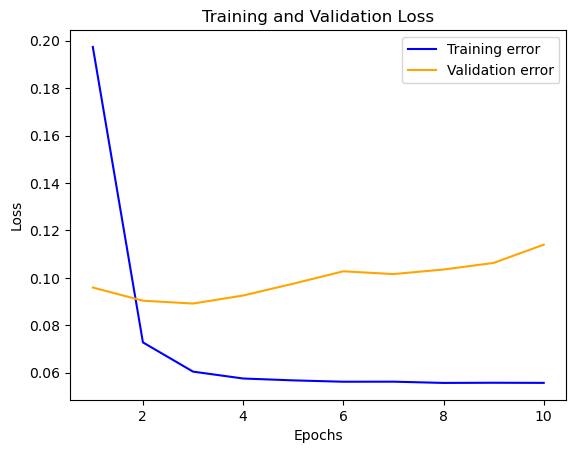

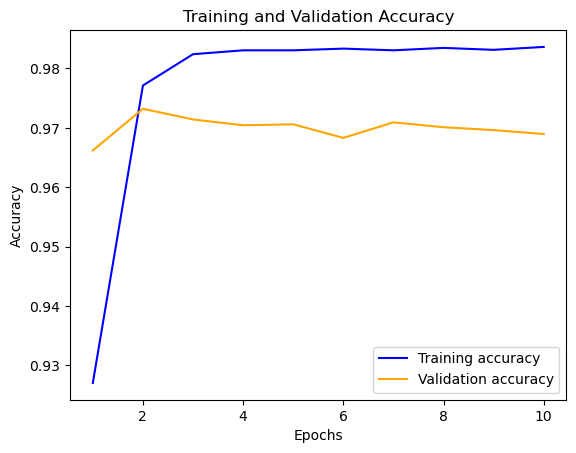

192/192 [==============================] - 1s 3ms/step


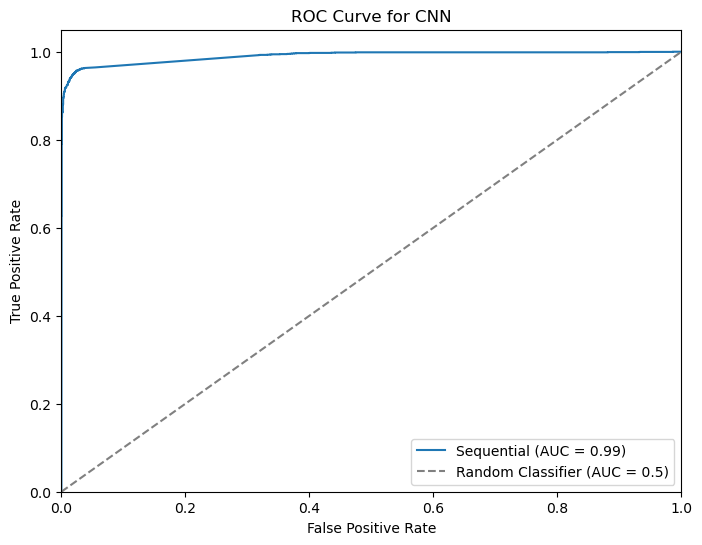

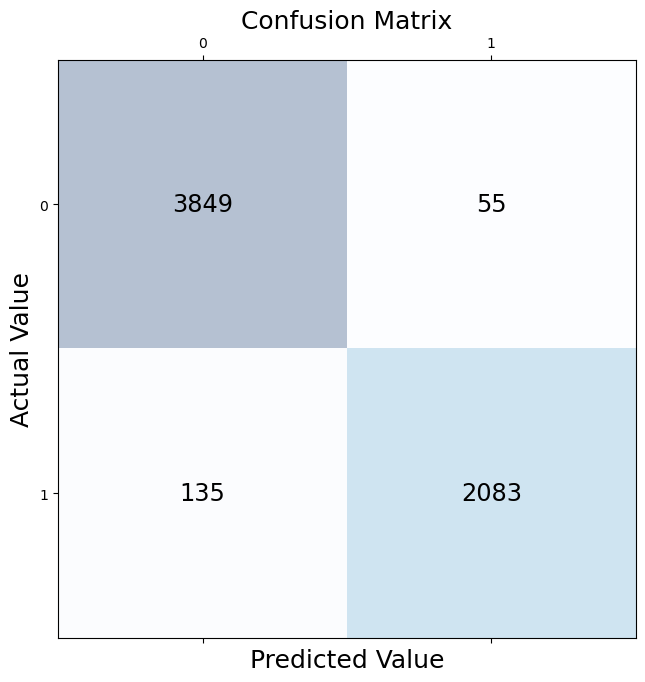

               precision    recall  f1-score   support

Non-Intrusion       0.97      0.99      0.98      3904
    Intrusion       0.97      0.94      0.96      2218

     accuracy                           0.97      6122
    macro avg       0.97      0.96      0.97      6122
 weighted avg       0.97      0.97      0.97      6122



In [120]:
# Plots loss over epochs cnn
plot_history(history_cnn)
plot_historyAcc(history_cnn)
plot_roc_auc(model, X_test1, y_test)
plot_report(y_test, y_pred)

**Recurrent Neural Networks (RNNs):**

In [121]:
# Define the RNN model
model = models.Sequential(name="RNN")

model.add(layers.SimpleRNN(units=64, activation='relu', input_shape= train_shape))

# Add a Dense layer for classification (adjust units and activation as needed)
model.add(layers.Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_rnn = model.fit(X_train1, y_train, batch_size = 32, epochs = 10, validation_data = (X_test1, y_test))


Epoch 1/10
766/766 [==============================] - 7s 8ms/step - loss: 0.2230 - accuracy: 0.9196 - val_loss: 0.1285 - val_accuracy: 0.9477
Epoch 2/10
766/766 [==============================] - 6s 8ms/step - loss: 0.1028 - accuracy: 0.9632 - val_loss: 0.1034 - val_accuracy: 0.9650
Epoch 3/10
766/766 [==============================] - 6s 8ms/step - loss: 0.0716 - accuracy: 0.9795 - val_loss: 0.1007 - val_accuracy: 0.9662
Epoch 4/10
766/766 [==============================] - 6s 7ms/step - loss: 0.0620 - accuracy: 0.9823 - val_loss: 0.0982 - val_accuracy: 0.9659
Epoch 5/10
766/766 [==============================] - 6s 8ms/step - loss: 0.0586 - accuracy: 0.9829 - val_loss: 0.1014 - val_accuracy: 0.9655
Epoch 6/10
766/766 [==============================] - 6s 8ms/step - loss: 0.0571 - accuracy: 0.9833 - val_loss: 0.1034 - val_accuracy: 0.9665
Epoch 7/10
766/766 [==============================] - 6s 8ms/step - loss: 0.0561 - accuracy: 0.9837 - val_loss: 0.1085 - val_accuracy: 0.9649
Epoch 

In [122]:
y_pred = model.predict(X_test1).flatten()
# y_pred1 = [1 if x>-0.5 else 0 for x in y_pred]
y_pred = np.round(y_pred)
print(f"Accuracy of RNN on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of RNN on test set : {f1_score(y_pred, y_test)}")

# Updates model score to f1_dict
f1_dict["RNN"] = f1_score(y_pred, y_test)
precision_dict["RNN"] = precision_score(y_pred, y_test)
recall_dict["RNN"] = recall_score(y_pred, y_test)
accuracy_dict['RNN'] = accuracy_score(y_pred, y_test)

192/192 [==============================] - 1s 4ms/step
Accuracy of RNN on test set : 0.967984318850049
F1 Score of RNN on test set : 0.954650624710782


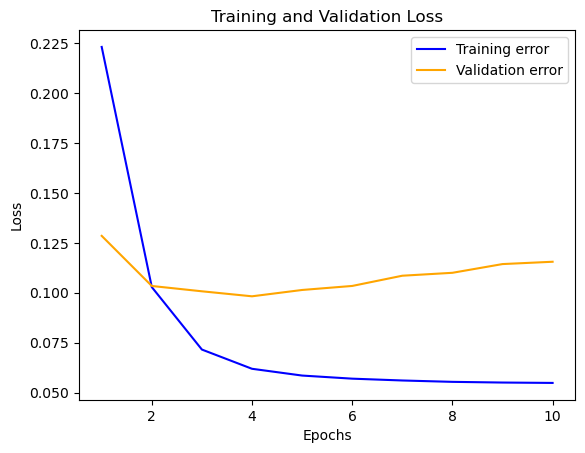

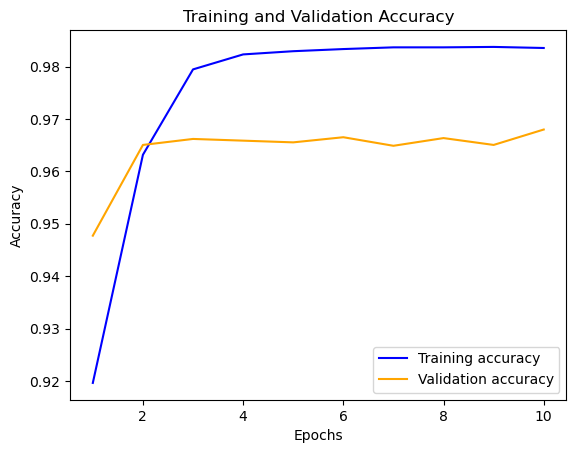

192/192 [==============================] - 1s 4ms/step


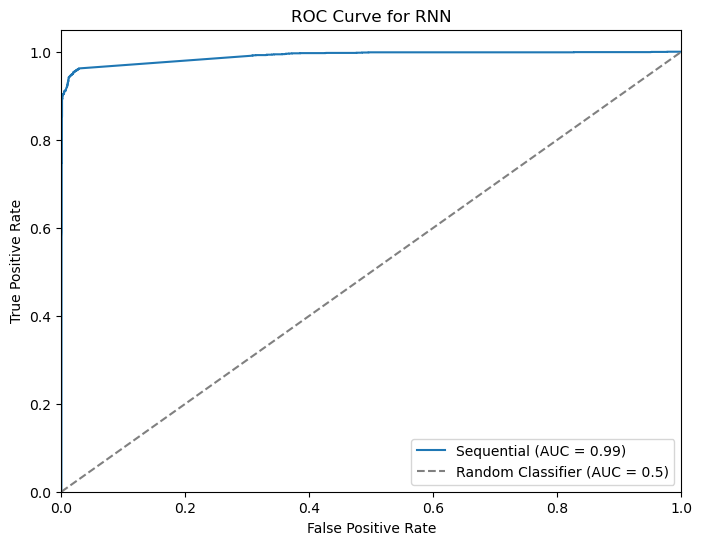

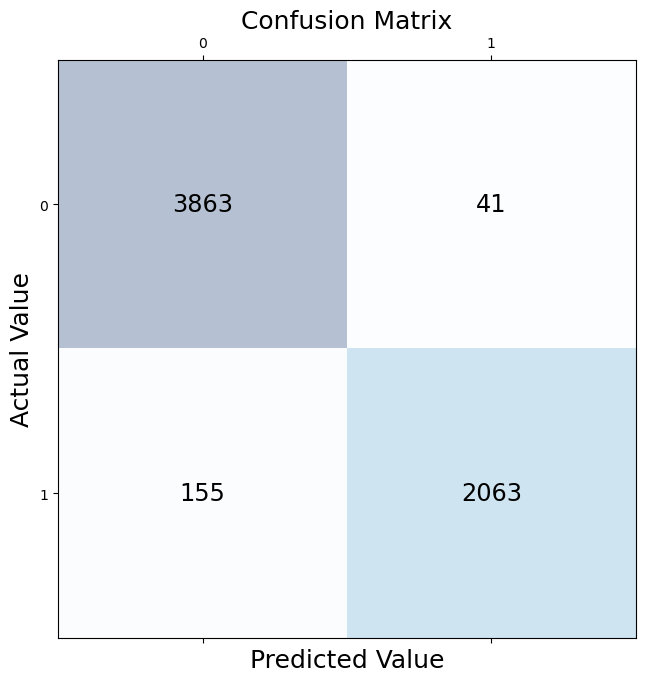

               precision    recall  f1-score   support

Non-Intrusion       0.96      0.99      0.98      3904
    Intrusion       0.98      0.93      0.95      2218

     accuracy                           0.97      6122
    macro avg       0.97      0.96      0.96      6122
 weighted avg       0.97      0.97      0.97      6122



In [123]:
plot_history(history_rnn)
plot_historyAcc(history_rnn)
plot_roc_auc(model, X_test1, y_test)
plot_report(y_test, y_pred)

## Transformer

In [ ]:
from tensorflow.keras.models import Model
# Define the transformer architecture
def transformer_encoder(inputs, head_size, ff_dim, dropout=0, name="Transformer"):
    # Normalization and Attention
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = Attention(use_scale=True, dropout=dropout)([x, x])

    # Feed Forward Part
    y = x  # For the skip connection
    x = LayerNormalization(epsilon=1e-6)(x)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dense(inputs.shape[-1])(x)
    x = tf.keras.layers.Dropout(dropout)(x)

    return tf.keras.layers.Add()([y, x])

def build_model(input_shape, head_size, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0, num_classes=1, name="transformer"):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size=head_size, ff_dim=ff_dim, dropout=dropout)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(mlp_dropout)(x)

    for dim in mlp_units:
        x = tf.keras.layers.Dense(dim, activation="relu")(x)
        x = tf.keras.layers.Dropout(mlp_dropout)(x)
    
    outputs = Dense(num_classes, activation="sigmoid")(x)

    return Model(inputs, outputs, name=name)

# Define hyperparameters
head_size = 256

ff_dim = 4
num_transformer_blocks = 4
mlp_units = [128]
mlp_dropout = 0.4
dropout = 0.25


# Build the model
model = build_model(train_shape, head_size, ff_dim, num_transformer_blocks, mlp_units, dropout=dropout, mlp_dropout=mlp_dropout)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary
history_transformer = model.fit(X_train1, y_train, batch_size = 32, epochs = 10, validation_data = (X_test1, y_test))


In [ ]:
y_pred = model.predict(X_test1).flatten()
# y_pred1 = [1 if x>-0.5 else 0 for x in y_pred]
y_pred = np.round(y_pred)
print(f"Accuracy of Transformer on test set : {accuracy_score(y_pred, y_test)}")
print(f"F1 Score of Transformer on test set : {f1_score(y_pred, y_test)}")

# Updates model score to f1_dict
f1_dict["Transformer"] = f1_score(y_pred, y_test)
precision_dict["Transformer"] = precision_score(y_pred, y_test)
recall_dict["Transformer"] = recall_score(y_pred, y_test)
accuracy_dict['Transformer'] = accuracy_score(y_pred, y_test)

In [ ]:
plot_history(history_transformer)
plot_historyAcc(history_transformer)
plot_roc_auc(model, X_test1, y_test)
plot_report(y_test, y_pred)

# FINAL PLOT FOR MODELS PERFORMANCE 

In [102]:
keys2 = f1_dict, precision_dict, recall_dict, accuracy_dict
metrics = ['F1_Score', 'Precision', 'Recall', 'Accuracy']
data = pd.DataFrame(keys2)
data.index = metrics
data

,CNN,RNN
F1_Score,0.945984,0.941066
Precision,0.903950,0.903052
Recall,0.992118,0.982422
Accuracy,0.962431,0.958837


In [ ]:
result = data.plot(kind='bar', rot=0, figsize=(15, 7));
result.legend(bbox_to_anchor=(1, 1.02), loc='upper left');